# Searching for and retrieving images

In this notebook, we show how to search for and retrieve images from VO services using the Registry and the __[Simple Image Access](http://www.ivoa.net/documents/SIA/)__ (SIA) protocol.

* [1. Finding](#finding) SIA resources from the Registry
* [2. Using](#sia) SIA to retrieve an image



####  (Note:  for all of these notebooks, the results depend on real-time queries.  Sometimes there are problems, either because a given service has changed, is undergoing maintenance, or the internet connectivity is having problems, etc.  Always retry a couple of times, come back later and try again, and only then send us the problem report to investigate.)

In [1]:
## For debugging navo_utils.  TO BE REMOVED
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import astropy
from IPython.display import Image as ipImage, display

## For development convenience, though it seems to make things error the second time a cell is run?
#%load_ext autoreload
#%autoreload 2

## NAVO utilities
#from navo_utils.image import Image, ImageColumn
#from navo_utils.registry import Registry

import pyvo as vo

## For handling ordinary astropy Tables
from astropy.table import Table

## For reading FITS files
import astropy.io.fits as apfits

## For pretty displays
import aplpy

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

/Users/tjaffe/anaconda3/envs/navo-py3/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  obj_type='module')


<a id="finding"></a>

# 1.  Finding SIA resources from the Registry

First, how do we find out what  services are available?  These are listed in a registry at STScI (__[see here](http://www.ivoa.net/documents/RegTAP/)__).  Our Registry function gives a simple interface for how to search for services.  

Let's search for services providing images in the ultraviolet bands:

In [3]:
uv_services=vo.regsearch(servicetype='image',waveband='uv')
uv_services.table['ivoid','short_name','res_title']

ivoid,short_name,res_title
object,object,object
ivo://archive.stsci.edu/sia/galex,GALEX,Galaxy Evolution Explorer
ivo://archive.stsci.edu/siap/hla,HLA,Hubble Legacy Archive
ivo://irsa.ipac/mast/scrapbook,MAST-Scrapbook,The MAST Image Scrapbook
ivo://irsa.ipac/spitzer/images/lvl,LVL,Spitzer Local Volume Legacy Survey
ivo://irsa.ipac/wise/images/z0mgs,z0MGS,The z=0 Multiwavelength Galaxy Synthesis
ivo://mast.stsci/acsggct,HST.ACSGGCT,ACS Galactic Globular Cluster Survey (ACSGGCT)
ivo://mast.stsci/angrrr,HST.ANGRRR,"Archive of Nearby Galaxies: Reduce, Reuse, Recycle (ANGRRR)"
ivo://mast.stsci/candels,CANDELS,Cosmic Assembly Near-IR Deep Extragalactic Legacy Survey (CANDELS)
ivo://mast.stsci/clash,HST.CLASH,Cluster Lensing And Supernova survey with Hubble (CLASH)


This returns an astropy table containing information about the services available.  We can then specify the service we want by using the corresponding row.  We'll repeat the search with additional qualifiers to isolate the row we want:

In [10]:
## In the keyword search, the "%" character is a wild card.
uvot_services=vo.regsearch(servicetype='image',waveband='uv',keywords=['swift'])
uvot_services.table['ivoid','short_name','res_title']

ivoid,short_name,res_title
object,object,object
ivo://nasa.heasarc/skyview/swiftuvot,SWIFTUVOT,Swift UVOT Combined V Intensity Images


This shows us that the data we are interested in comes from the HEASARC's SkyView service, but the point of these VO tools is that you don't need to know that ahead of time or indeed to care where it comes from.

<a id="sia"></a>

# 2. Using SIA to retrieve an image:

Now we look for images of our favorite source.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you can specify the central position and the size (degrees as one or two floats for the RA,DEC directions).  It is up to the service to determine how to provide this. Optionally, you can limit it to the format you want, e.g., "image/fits" or "image/png" etc.  

What is returned to you is not the image itself but a list of images available and how to access them.  This is easiest shown by example:  

In [105]:
import astropy.coordinates as coord
coords=coord.SkyCoord.from_name("m51")
im_table=uvot_services[0].search(pos=coords,size=0.2,format='image/jpeg')
im_table.table

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
swiftuvotvint,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574708935795&nofits=1&quicklook=jpeg&return=jpeg,1
swiftuvotbint,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574708936629&nofits=1&quicklook=jpeg&return=jpeg,2
swiftuvotuint,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574708939135&nofits=1&quicklook=jpeg&return=jpeg,3
swiftuvotuvw1int,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574708940965&nofits=1&quicklook=jpeg&return=jpeg,4
swiftuvotuvw2int,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotuvw2int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574708942788&nofits=1&quicklook=jpeg&return=jpeg,5
swiftuvotuvm2int,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=swiftuvotuvm2int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574708944922&nofits=1&quicklook=jpeg&return=jpeg,6


Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG.  

Note that different services will return different column names, but all will have a column giving the URL to access the image.  Though it has different column names in different services, it is always identifiable by the UCD 'VOX:Image_AccessReference'.  (This we will make more user friendly.)

In [106]:
#url=im_table[0].getbyucd('VOX:Image_AccessReference').decode()
#print(url)

### Resulting image

Since we have asked for JPEG images, we can display it in python easily by using its URL. Each row of the result has a getdataurl() method, and you can then hand the URL to an image displayer such as IPython.display:

In [109]:
from IPython.display import Image as ipImage, display
img = ipImage(url=im_table[0].getdataurl())
display(img)

Or download the FITS image and display it with:

(This often errors off with a time out message.  Just try it again, possibly a couple of times.)

In [113]:
from astropy.io import fits
#  Do the search again asking for FITS
im_table=uvot_services[0].search(pos=coords,size=0.2,format='image/fits')
#  Hand the url of the first result to fits.open()
hdu_list=fits.open(im_table[0].getdataurl())

In [111]:
hdu_list

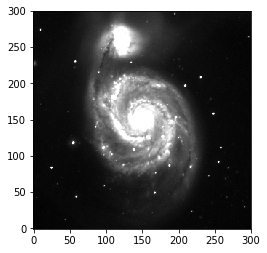

In [112]:
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.1)

### Now with aplpy

This package knows how to read the header keywords in WCS to display the correct coordinate axes.  

INFO: Auto-setting vmin to  1.285e-02 [aplpy.core]


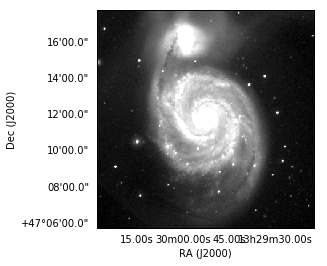

In [47]:
gc = aplpy.FITSFigure(hdu_list,figsize=(4, 4))
gc.show_grayscale(stretch='log', vmax=0.1)

### A related example with several services offering the same data:
Suppose we want Sloan DSS data.  A generic query finds us a number of possibilities (note that this doesn't work for keywords=['sdss'];  be flexible and try several search terms):

In [72]:
services=vo.regsearch(servicetype='image',keywords=['sloan'],waveband='optical')
services.table[np.where(np.isin(services.table['short_name'],b'SDSSDR7'))]['ivoid','short_name']

ivoid,short_name
object,object
ivo://nasa.heasarc/skyview/sdssdr7,SDSSDR7
ivo://sdss.jhu/services/siapdr7-images,SDSSDR7


So one of these is served by SDSS's SkyServer and the other by HEASARC's SkyView.  

In [116]:
heasarc_dr7_service=services[int(np.where(np.isin(services.table['short_name'],b'SDSSDR7'))[0][0])]
jhu_dr7_service=services[int(np.where(np.isin(services.table['short_name'],b'SDSSDR7'))[0][1])]

In [139]:
sdss_table_heasarc=heasarc_dr7_service.search(pos=coords,size=0.2,format='image/fits')
sdss_table_heasarc.table

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
sdssdr7g,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7g&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574711248519&return=FITS,1
sdssdr7i,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7i&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574711249134&return=FITS,2
sdssdr7u,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7u&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574711249622&return=FITS,3
sdssdr7r,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7r&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574711250125&return=FITS,4
sdssdr7z,202.469575,47.19525833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.19525833&survey=sdssdr7z&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1574711250804&return=FITS,5


To Be Fixed:  URL returned above has hard-wired "format=image/fits".  If you specify anythign else, it errors.  If you specify nothing, then the search() method puts "format=all", which errors.  So specify empty string for now.

In [140]:
sdss_table_jhu=jhu_dr7_service.search(pos=coords,size=0.2,format='')
sdss_table_jhu.table

Title,width,height,size,RA,DEC,scale,format,url,equinox,naxes,naxis,crtype,crpix,crval,cdval
object,int32,int32,float64,float64,float64,object,object,object,float64,int32,object,object,object,object,object
Sloan Digital Sky Survey - Filter u,2048,1489,3049472.0,202.439715840115,47.1222952774076,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-u6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.439715840115 47.1222952774076],[3.57829352076884e-05 0.000157654334590212 0.000107291403325821 -2.42761847386219e-05]
Sloan Digital Sky Survey - Filter g,2048,1489,3049472.0,202.438763451233,47.1224982411069,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-g6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.438763451233 47.1224982411069],[3.57455198349534e-05 0.000157658871914506 0.000107248674325512 -2.4298297148212e-05]
Sloan Digital Sky Survey - Filter r,2048,1489,3049472.0,202.440760551524,47.1223224530134,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-r6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.440760551524 47.1223224530134],[3.57284422970295e-05 0.000157658504949188 0.000107285884319316 -2.43020165047957e-05]
Sloan Digital Sky Survey - Filter i,2048,1489,3049472.0,202.440280828514,47.1221470640024,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-i6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.440280828514 47.1221470640024],[3.57634273620044e-05 0.00015761708892598 0.000107330126376146 -2.43196618936367e-05]
Sloan Digital Sky Survey - Filter z,2048,1489,3049472.0,202.439529079822,47.1222577816612,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-z6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.439529079822 47.1222577816612],[3.57150015372814e-05 0.000157643765195985 0.000107288170305585 -2.43520424844304e-05]
Sloan Digital Sky Survey - Filter u,2048,1489,3049472.0,202.471051455651,47.3353076054504,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-u6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.471051455651 47.3353076054504],[3.59720233632108e-05 0.000158234026889022 0.000107269639460545 -2.43685414700374e-05]
Sloan Digital Sky Survey - Filter g,2048,1489,3049472.0,202.470063167219,47.3355466663192,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-g6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.470063167219 47.3355466663192],[3.59432847686782e-05 0.000158250992709564 0.000107232188959642 -2.43648103577398e-05]
Sloan Digital Sky Survey - Filter r,2048,1489,3049472.0,202.472135546076,47.3353955051599,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-r6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.472135546076 47.3353955051599],[3.59415181020478e-05 0.000158248434019201 0.000107267969211639 -2.43568204128413e-05]
Sloan Digital Sky Survey - Filter i,2048,1489,3049472.0,202.471591570338,47.3352202087437,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-i6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.471591570338 47.3352202087437],[3.59688512209066e-05 0.000158230937820391 0.000107320614280034 -2.43668898148645e-05]


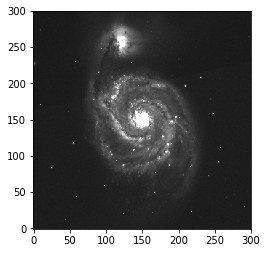

In [145]:
#  Get the filter g version
hdu_list=fits.open(sdss_table_heasarc[0].getdataurl())
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmin=1e3,vmax=1.5e3)

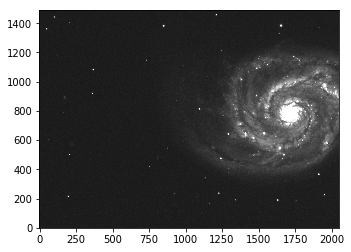

In [146]:
#  Get the filter g version
hdu_list=fits.open(sdss_table_jhu[1].getdataurl())
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmin=1e3,vmax=1.5e3)

But it turns out that SkyView is just getting it by using the SIAP internally to get the data from the SDSS service.  The point of the VO protocols is that you don't need to know where the data are coming from.  But they can be processed differently.  